In [27]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

import warnings
warnings.filterwarnings("ignore")

In [28]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

## Lag Plots to visually check for stationarity

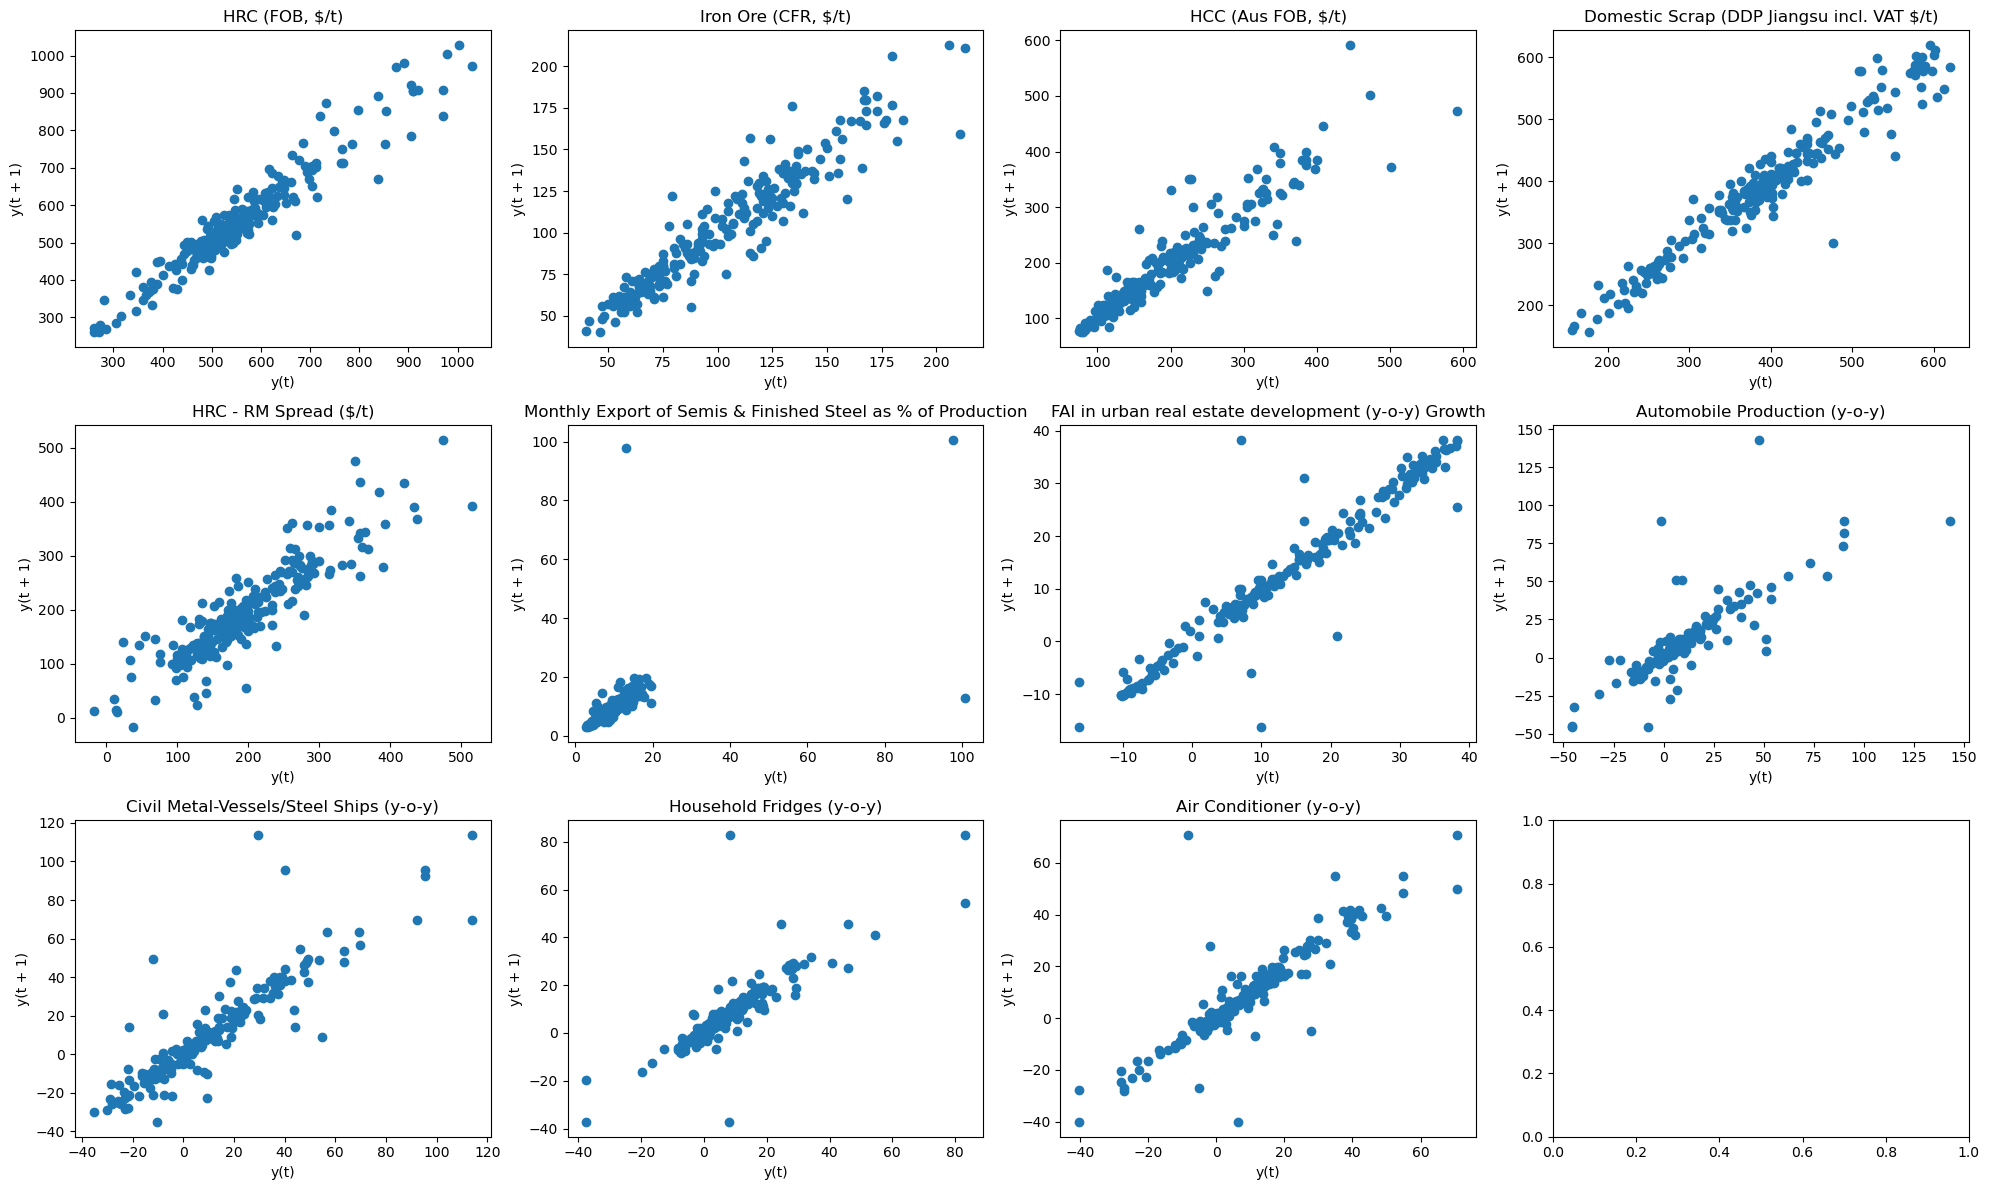

In [31]:
# Columns to plot
factors = [col for col in df.columns if col not in ['Date']]

n_cols = 4
n_rows = -(-len(factors) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(factors):
    lag_plot(df[col], lag=1, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


## ADF Test for Stationarity

In [32]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

def adf_results(df):
    adf_df = adf_test(df)
    stationary_cols = adf_df.columns[adf_df.loc['p-value'] < 0.05]
    non_stationary_cols = adf_df.columns[adf_df.loc['p-value'] >= 0.05]

    return stationary_cols, non_stationary_cols

In [33]:
# Columns to run ADF test on
factors = [col for col in df.columns if col not in ['Date']]
# df with only the factors
df_factors = df[factors]

# Conduct ADF test
stationary_adf, non_stationary_adf = adf_results(df_factors)

results_df_adf = pd.DataFrame({
    '': ['Name', 'Number of columns'],
    'Stationary Columns': [stationary_adf, len(stationary_adf)],
    'Non-Stationary Columns': [non_stationary_adf, len(non_stationary_adf)]
})
results_df_adf.style

,,Stationary Columns,Non-Stationary Columns
0,Name,"Index(['HRC (FOB, $/t)', 'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)', 'HRC - RM Spread ($/t)', 'Monthly Export of Semis & Finished Steel as % of Production', 'Automobile Production (y-o-y)', 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'], dtype='object')","Index(['Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'FAI in urban real estate development (y-o-y) Growth', 'Civil Metal-Vessels/Steel Ships (y-o-y)'], dtype='object')"
1,Number of columns,8,3


From the ADF test, there are 8 stationary columns:
1. HRC (FOB, $/t)
2. Iron Ore (CFR, $/t)
3. HCC (Aus FOB, $/t)
4. HRC - RM Spread ($/t)
5. Monthly Export of Semis & Finished Steel as % of Production
6. Automobile Production (y-o-y)
7. Household Fridges (y-o-y)
8. Air Conditioner (y-o-y)

There are 3 non-stationary columns:
1. Domestic Scrap (DDP Jiangsu incl. VAT $/t)
2. FAI in urban real estate development (y-o-y) Growth
3. Civil Metal-Vessels/Steel Ships (y-o-y)

## Check again with KPSS Test for stationarity

In [34]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

def kpss_results(df):
    kpss_df = kpss_test(df)
    stationary_cols = kpss_df.columns[kpss_df.loc['p-value'] >= 0.05]
    non_stationary_cols = kpss_df.columns[kpss_df.loc['p-value'] < 0.05]

    return stationary_cols, non_stationary_cols

In [35]:
# Conduct KPSS test
stationary_kpss, non_stationary_kpss = kpss_results(df_factors)

results_df_kpss = pd.DataFrame({
    '': ['Name', 'Number of columns'],
    'Stationary Columns': [stationary_kpss, len(stationary_kpss)],
    'Non-Stationary Columns': [non_stationary_kpss, len(non_stationary_kpss)]
})
results_df_kpss.style

,,Stationary Columns,Non-Stationary Columns
0,Name,"Index(['HRC - RM Spread ($/t)', 'Monthly Export of Semis & Finished Steel as % of Production', 'FAI in urban real estate development (y-o-y) Growth', 'Automobile Production (y-o-y)', 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'], dtype='object')","Index(['HRC (FOB, $/t)', 'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)', 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'Civil Metal-Vessels/Steel Ships (y-o-y)'], dtype='object')"
1,Number of columns,6,5


From the KPSS test, there are 6 stationary columns:
1. HRC - RM Spread ($/t)
2. Monthly Export of Semis & Finished Steel as % of Production
3. FAI in urban real estate development (y-o-y) Growth
4. Automobile Production (y-o-y)
5. Household Fridges (y-o-y)
6. Air Conditioner (y-o-y)

There are 5 non-stationary columns:
1. HRC (FOB, $/t)
2. Iron Ore (CFR, $/t)
3. HCC (Aus FOB, $/t)
4. Domestic Scrap (DDP Jiangsu incl. VAT $/t)
5. Civil Metal-Vessels/Steel Ships (y-o-y)

## Apply differencing to non-stationary columns
Since there are non-stationary columns, differencing will be done until all the columns are stationary.

In [36]:
def apply_differencing(df, cols):
    for col in cols:
        df[col] = df[col] - df[col].shift(1)
    return df

In [37]:
def check_stationarity(non_stationary_adf, non_stationary_kpss, df, count=0):
    # Combine non-stationary columns from both tests
    non_stationary_combined = set(non_stationary_adf).union(set(non_stationary_kpss))
    
    if len(non_stationary_combined) == 0:
        print(f"All columns stationary after {count} round(s) of differencing.")
        return count, df

    # Apply differencing for non-stationary columns
    df_differenced = apply_differencing(df, non_stationary_combined)

    # Conduct ADF test again
    stationary_adf2, non_stationary_adf2 = adf_results(df_differenced)
    # Conduct KPSS test again
    stationary_kpss2, non_stationary_kpss2 = kpss_results(df_differenced)

    # Update number of times differencing was done
    count += 1

    print(f"Round {count}:")
    print(f"Num of Stationary columns (ADF): {len(stationary_adf2)}, Num of Stationary columns (KPSS): {len(stationary_kpss2)}")
    print(f"Non-stationary columns after differencing: {set(non_stationary_adf2).union(non_stationary_kpss2)}\n")

    return check_stationarity(non_stationary_adf2, non_stationary_kpss2, df_differenced, count)


In [38]:
num_rounds, differenced_df = check_stationarity(non_stationary_adf, non_stationary_kpss, df[factors])

Round 1:
Num of Stationary columns (ADF): 11, Num of Stationary columns (KPSS): 11
Non-stationary columns after differencing: set()

All columns stationary after 1 round(s) of differencing.


In [45]:
# Add the excluded columns back in -> all columns of df_updated are stationary
removed_cols = ['Date']
df_updated = df[removed_cols].copy()
df_updated = pd.concat([df[removed_cols], differenced_df], axis=1)

print(df_updated.shape)
print(df_updated.head())

(229, 12)
         Date  HRC (FOB, $/t)  Iron Ore (CFR, $/t)  HCC (Aus FOB, $/t)  \
0  2006-01-01             NaN                  NaN                 NaN   
1  2006-02-01             0.0                  1.0                 0.0   
2  2006-03-01            61.0                  2.0                 0.0   
3  2006-04-01            29.0                  7.0                -9.0   
4  2006-05-01            27.0                 -1.0                 0.0   

   Domestic Scrap (DDP Jiangsu incl. VAT $/t)  HRC - RM Spread ($/t)  \
0                                         NaN                    187   
1                                         0.0                    185   
2                                         3.0                    244   
3                                         6.0                    271   
4                                         6.0                    300   

   Monthly Export of Semis & Finished Steel as % of Production  \
0                                             